In [11]:
import random
import os
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union
from rasterio.features import rasterize
from rasterio.transform import from_bounds
from scipy.ndimage import distance_transform_edt, label
from IPython.display import clear_output
from PIL import Image
from skimage.measure import find_contours

## **Load Data and Voronoi Districts**

In [12]:

# =======================
# Loading data
# =======================

precinct_shapefile = 'va_2016/va_2016.shp'
votes_gdf = gpd.read_file(precinct_shapefile)

# calculate votes (blue = democrat, red = republican)
votes_gdf['blue'] = votes_gdf['G16PREDCLI'] 
votes_gdf['red'] = votes_gdf['G16PRERTRU']

total_republican_votes = votes_gdf['G16PRERTRU'].sum()

print(f"Total Republican Votes: {total_republican_votes}")

total_dem = votes_gdf['G16PREDCLI'].sum()

print(f"Total Dem Votes: {total_dem}")


# Reproject to a Projected CRS
votes_gdf_projected = votes_gdf.to_crs(epsg=3857)


# calculate area to get pop per pixel
votes_gdf_projected['area'] = votes_gdf_projected.geometry.area


# =======================
# Rasterizing
# =======================

# select columns to be rasterized
# (to calculate total votes per pixel)
selected_columns = ['blue', 'red']

# get coordinates
minx, miny, maxx, maxy = votes_gdf_projected.total_bounds
pixel_size = 6000  # Adjust pixel size as needed (in meters)
width = int(np.ceil((maxx - minx) / pixel_size))
height = int(np.ceil((maxy - miny) / pixel_size))
transform = from_bounds(minx, miny, maxx, maxy, width, height)

# rasterize attributes
# Normalize votes by area (vote density)
votes_gdf_projected['blue_density'] = votes_gdf_projected['blue'] / votes_gdf_projected['area']
votes_gdf_projected['red_density'] = votes_gdf_projected['red'] / votes_gdf_projected['area']

# Rasterize the vote densities instead of raw vote counts
raster_bands = []
for col in ['blue_density', 'red_density']:
    # Create shapes for rasterization with normalized values
    shapes = (
        (geom, value)
        for geom, value in zip(votes_gdf_projected.geometry, votes_gdf_projected[col])
    )
    raster_band = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='float32'
    )
    raster_bands.append(raster_band)

# Multiply the rasterized densities by the pixel area to get total votes per pixel
blue_band, red_band = [band * (pixel_size ** 2) for band in raster_bands]

population = blue_band + red_band 

# =======================
# Virginia mask
# this part ignores pixels that are not within Virginia
# =======================

# get the boundary of Virginia state
florida_union = votes_gdf_projected.union_all()

# Ensure the union is a Polygon or MultiPolygon
if not isinstance(florida_union, (Polygon, MultiPolygon)):
    raise ValueError("Unexpected geometry type for unary_union. Expected Polygon or MultiPolygon.")

# Rasterize the boundary to create a mask
florida_mask = rasterize(
    [(florida_union, 1)], # 1 is pixel is inside, 0 otherwise
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='uint8'
)

# Apply the Virginia mask to the population array
# Pixels outside Virginia will have population = 0
population_masked = population * florida_mask

print("Total population within Virginia:", population_masked.sum())
print("Target population per district:", population_masked.sum() / 11)


Total Republican Votes: 1769443
Total Dem Votes: 1981473
Total population within Virginia: 3809870.5
Target population per district: 346351.88


In [35]:
def generate_voronoi_districts_with_bias(
    population_masked, 
    num_districts=11, 
    bias_factor=2.0, 
    random_seed=None
):
    """
    Generates Voronoi-based districts within Virginia based on a population raster,
    with a bias toward more populated areas for district centers. Includes visualizations.

    Parameters:
        population_masked (np.ndarray): 2D array representing population per pixel within Virginia.
        num_districts (int): Number of districts to generate. Default is 11.
        bias_factor (float): Factor to control bias toward populated areas. Default is 2.0.
        random_seed (int, optional): Seed for random number generator for reproducibility.

    Returns:
        district_map (np.ndarray): 2D array with district IDs assigned to each pixel. Pixels outside Virginia are -1.
        seed_coords (np.ndarray): Array of shape (num_districts, 2) with seed pixel coordinates (row, column).
        target_pop (float): Target population per district.
    """
    # Set seed for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)

    # Calculate total and target population
    total_pop = population_masked.sum()
    target_pop = total_pop / num_districts

    # Get pixels within Virginia
    valid_pixels = np.argwhere(population_masked > 0)
    valid_population = population_masked[population_masked > 0]
    
    if len(valid_pixels) < num_districts:
        raise ValueError("Not enough valid pixels to assign to districts.")

    # Increase bias by scaling population values
    biased_population = valid_population ** bias_factor
    probabilities = biased_population / biased_population.sum()

    # Sample seed coordinates with bias
    seed_indices = np.random.choice(len(valid_pixels), size=num_districts, replace=False, p=probabilities)
    seed_coords = valid_pixels[seed_indices]

    # Create an empty district map
    height, width = population_masked.shape
    district_map = -1 * np.ones((height, width), dtype=int)

    # Assign each sampled pixel to a district
    for d_id, (r, c) in enumerate(seed_coords):
        district_map[r, c] = d_id

    # Compute Voronoi Tessellation
    seed_mask = np.zeros((height, width), dtype=bool)
    seed_mask[seed_coords[:, 0], seed_coords[:, 1]] = True

    distance, indices = distance_transform_edt(~seed_mask, return_indices=True)
    nearest_row = indices[0]
    nearest_col = indices[1]
    nearest_district = district_map[nearest_row, nearest_col]

    district_map[population_masked > 0] = nearest_district[population_masked > 0]

    # =======================
    # Calculate Population per District
    # =======================

    # Initialize lists to store data for each district
    district_ids = range(num_districts)
    total_population = []

    for d_id in district_ids:
        mask = (district_map == d_id)
        pop = population_masked[mask].sum()
        total_population.append(pop)

    # Create a DataFrame for plotting
    df = pd.DataFrame({
        'District': district_ids,
        'Total Population': total_population,
    })

    return district_map, seed_coords, target_pop, df


In [60]:
district_map, seed_coords, target_pop, df = generate_voronoi_districts_with_bias(population_masked, 11, 1.2, random_seed=6
                                                                                )

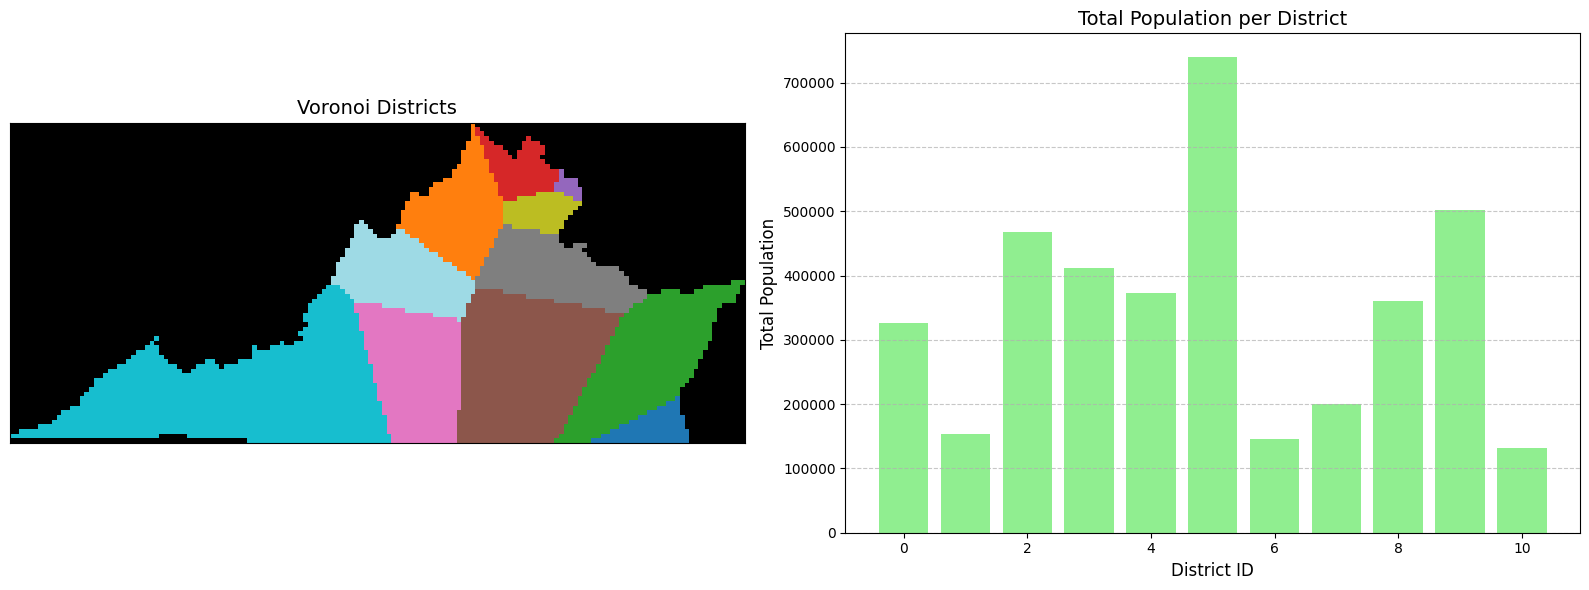

In [61]:
# =======================
# Visualization
# =======================

num_districts=11

district_colors = plt.get_cmap('tab20', num_districts).colors[:num_districts]
colors = list(district_colors) + [(0, 0, 0, 1)]  # Adding black for ocean
custom_cmap = ListedColormap(colors)

# Adjust district_map to Shift -1 to the Last Index (for black color)
district_map_shifted = district_map.copy()
district_map_shifted[district_map_shifted == -1] = num_districts  # Assign -1 to black

# Combine all plots in 1 row, 3 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Voronoi Districts
im = axes[0].imshow(
    district_map_shifted,
    cmap=custom_cmap,
    interpolation='nearest',
    origin='upper'
)
axes[0].grid(False)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Voronoi Districts", fontsize=14)

# Plot 2: Total Population per District
axes[1].bar(df['District'], df['Total Population'], color='lightgreen')
axes[1].set_xlabel('District ID', fontsize=12)
axes[1].set_ylabel('Total Population', fontsize=12)
axes[1].set_title('Total Population per District', fontsize=14)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## **Remove Islands**

In [ ]:
def enforce_largest_connected_component(district_map):
    """
    Enforce contiguity by retaining only the largest connected component
    across the entire district map, removing all other smaller components.

    Parameters:
        district_map (np.ndarray): 2D array with district IDs (>= 0) and -1 for outside areas.

    Returns:
        np.ndarray: Updated district map with only the largest connected component retained.
    """
    # Mask to ignore ocean/outside (-1)
    valid_mask = district_map >= 0

    # Label connected components across the entire map
    labeled, num_components = label(valid_mask)

    if num_components <= 1:
        return district_map 

    # Find the largest connected component
    component_sizes = [(comp_label, np.sum(labeled == comp_label)) for comp_label in range(1, num_components + 1)]
    largest_label = max(component_sizes, key=lambda x: x[1])[0]  # Find label with the largest size

    # Create a mask for the largest connected component
    largest_component_mask = (labeled == largest_label)

    # Set all other regions to -1 (outside)
    district_map[~largest_component_mask] = -1

    return district_map

In [39]:
district_map = enforce_largest_connected_component(district_map)

## **Optimization**

### Logistic Regression

In [40]:
def logistic_regression_probability(percent_red, w0, w1):
    """
    Compute the probability of a Republican win using a logistic regression model.

    Parameters:
        percent_red (float): Percentage of Republican voters in the district.
        w0 (float): Intercept term.
        w1 (float): Coefficient for percent_red.

    Returns:
        float: Probability of Republican win.
    """
    return 1 / (1 + np.exp(-(w0 + w1 * (percent_red - 50))))

### Plotting Function

In [41]:
def plot_district_map_with_population_interactive(
    district_map,
    pop_dict,
    favorability_dict,       # Favorability scores per district
    num_districts,
    ci_lower,
    ci_upper,
    minx, maxx, miny, maxy,  # Spatial bounds for plotting 
    iteration=None,
    population_losses=None,
    compactness_losses=None,
    favorability_losses=None,
    favorability_losses_4years=None,
    favorability_losses_8years=None,
    total_losses=None,
    red_votes_dict=None,
    temperatures=None,
    gamma=None,
    save_frame=False,
    frame_paths=None
):
    """
    Dynamically visualize the district map, population chart, favorability, and loss curves.
    """
    # Clear the current output in Jupyter or console
    clear_output(wait=True)

    # Calculate population and favorability per district
    district_ids = np.unique(district_map[district_map >= 0])
    total_population = [pop_dict[d_id] for d_id in district_ids]
    total_favorability = [favorability_dict[d_id] for d_id in district_ids]
    total_vote_share = [(red_votes_dict[d_id] / pop_dict[d_id]) * 100.0 for d_id in district_ids]

    # Create a color list based on favorability
    colors = []
    for f in total_favorability:
        if f > 0.5:
            norm_f = (f - 0.5) / 0.5
            color = plt.cm.Reds(norm_f)
        else:
            norm_f = 1 - (f / 0.5)
            color = plt.cm.Blues(norm_f)
        colors.append(color)
    colors.append((0, 0, 0, 1))  # Add black for ocean/background
    custom_cmap = ListedColormap(colors)

    district_map_shifted = district_map.copy()
    district_map_shifted[district_map_shifted == -1] = num_districts

    # expected won this year, +4 years, and +8 years
    expected_won = 11 - np.array(favorability_losses) / gamma if (favorability_losses is not None and gamma is not None) else []
    expected_won_4 = 11 - np.array(favorability_losses_4years) / gamma if (favorability_losses_4years is not None and gamma is not None) else []
    expected_won_8 = 11 - np.array(favorability_losses_8years) / gamma if (favorability_losses_8years is not None and gamma is not None) else []

    # Initialize the GridSpec layout
    fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(4, 4, figure=fig)

    # Plot the district map (span 2 rows and all columns)
    ax_map = fig.add_subplot(gs[:2, :])
    im = ax_map.imshow(
        district_map_shifted,
        cmap=custom_cmap,
        interpolation='nearest',
        origin='upper',
        extent=(minx, maxx, miny, maxy)
    )
    ax_map.grid(False)
    ax_map.set_xticks([])
    ax_map.set_yticks([])
    title = "District Map"
    if iteration is not None:
        title += f" - Iteration {iteration}"
    ax_map.set_title(title, fontsize=16)

    # Plot Total Population per District
    ax_pop = fig.add_subplot(gs[2, 0])
    ax_pop.bar(district_ids, total_population, color='lightgreen')
    ax_pop.set_xlabel('District ID')
    ax_pop.set_ylabel('Total Population')
    ax_pop.set_title('Total Population per District')
    ax_pop.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot Favorability per District
    ax_fav = fig.add_subplot(gs[2, 1])
    ax_fav.bar(district_ids, total_favorability, color='salmon')
    ax_fav.set_xlabel('District ID')
    ax_fav.set_ylabel('Favorability')
    ax_fav.set_title('Favorability per District')
    ax_fav.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot Loss and Temperature Over Iterations
    if all([population_losses, compactness_losses, favorability_losses, total_losses, temperatures]):
        ax_loss = fig.add_subplot(gs[2, 2])
        ax_loss.plot(population_losses, label="Population Loss", color="blue")
        ax_loss.plot(compactness_losses, label="Compactness Loss", color="green")
        ax_loss.plot(favorability_losses, label="Favorability Loss", color="red")
        ax_loss.plot(total_losses, label="Total Loss", color="purple")
        # ax_loss.plot(temperatures, label="Temperature", color="orange")
        ax_loss.set_xlabel('Iteration')
        ax_loss.set_ylabel('Loss / Temperature')
        ax_loss.set_title('Loss and Temperature Over Iterations')
        ax_loss.legend()
        ax_loss.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot Expected Number of Districts Won
    if expected_won is not None:
        ax_exp = fig.add_subplot(gs[2, 3])
        ax_exp.plot(expected_won, color="red", label="2012")
        ax_exp.plot(expected_won_4, color="black", label="2016")
        ax_exp.plot(expected_won_8, color="gray", label="2020")
        ax_exp.fill_between(
            range(len(expected_won)),
            ci_lower, ci_upper,
            color="salmon", alpha=0.2, label="95% CI"
        )
        ax_exp.set_xlabel('Iteration')
        ax_exp.set_ylabel('Expected Wins')
        ax_exp.set_title('Expected Number of Districts Won')
        ax_exp.legend()
    
    # Plot vote share
    if red_votes_dict is not None:
        ax_votes = fig.add_subplot(gs[3, 1:3])
        ax_votes.bar(district_ids, total_vote_share, color="tomato")
        ax_votes.axhline(y=50, color='black', linestyle='--', linewidth=1)
        ax_votes.set_xlabel('District')
        ax_votes.set_ylabel('Proportion of Republican Votes')
        ax_votes.set_title('Vote Share per District')

    plt.tight_layout()

    # Save the frame as an image if required
    if save_frame and frame_paths is not None:
        if not os.path.exists("gif_va"):
            os.makedirs("gif_va")  # Create the folder if it doesn't exist
        frame_path = os.path.join("gif_va", f"frame_{iteration:04d}.png")
        frame_paths.append(frame_path)
        plt.savefig(frame_path)
    
    plt.show()

    plt.close(fig)

    return fig

### District Votes and Population

In [42]:
def calculate_district_votes(district_map, red_band):
    """
    Calculate the total Republican votes for each district.

    Parameters:
        district_map (np.ndarray): 2D array of district assignments.
        red_band (np.ndarray): 2D array of Republican votes per pixel.

    Returns:
        dict: Dictionary mapping district IDs to total Republican votes.
    """
    unique_districts = np.unique(district_map)
    unique_districts = unique_districts[unique_districts >= 0]
    red_votes_dict = {}
    for d_id in unique_districts:
        red_votes_dict[d_id] = red_band[district_map == d_id].sum()
    return red_votes_dict

def calculate_district_data(district_map, population_masked, red_band):
    """
    Calculate population and Republican votes for each district.

    Parameters:
        district_map (np.ndarray): 2D array of district assignments.
        population_masked (np.ndarray): 2D array of population per pixel.
        red_band (np.ndarray): 2D array of Republican votes per pixel.

    Returns:
        tuple: (pop_dict, red_votes_dict)
    """
    unique_districts = np.unique(district_map)
    unique_districts = unique_districts[unique_districts >= 0]
    pop_dict = {}
    red_votes_dict = {}
    for d_id in unique_districts:
        mask = (district_map == d_id)
        pop_dict[d_id] = population_masked[mask].sum()
        red_votes_dict[d_id] = red_band[mask].sum()
    return pop_dict, red_votes_dict

### Compactness

In [43]:
def calculate_compactness(district_map, district_id):
    """
    Calculate the compactness (perimeter-to-area ratio) of a district.

    Parameters:
        district_map (np.ndarray): 2D array of district IDs.
        district_id (int): ID of the district to evaluate.

    Returns:
        float: Compactness score (lower is better).
    """
    # Create a mask for the district
    district_mask = (district_map == district_id)
    if not district_mask.any():  # Skip if the district does not exist
        return float('inf')

    # Find the contours of the district
    contours = find_contours(district_mask.astype(int), 0.5)
    if not contours:
        return float('inf')  # No valid contours

    # Create polygons from contours
    polygons = []
    for contour in contours:
        if len(contour) > 2:  # Ensure at least 3 points
            poly = Polygon(contour)
            if poly.is_valid and poly.area > 0:  # Filter invalid or zero-area polygons
                polygons.append(poly)

    if not polygons:
        return float('inf')  # No valid polygons

    # Union all regions to form the full district geometry
    try:
        district_polygon = unary_union(polygons)
    except Exception as e:
        print(f"Error during union operation: {e}")
        return float('inf')

    # Calculate compactness = Perimeter / sqrt(Area)
    perimeter = district_polygon.length
    area = district_polygon.area
    if area == 0:
        return float('inf')  # Avoid division by zero

    return perimeter / (area ** 0.5)

### Loss Functions

In [44]:
def calculate_loss(district_map, pop_dict, red_votes_dict, target_pop, alpha, beta, gamma, w0=-5, w1=0.1):
    """
    Calculate the combined loss including population imbalance, compactness, and party favorability.

    Parameters:
        district_map (np.ndarray): 2D array of district assignments.
        pop_dict (dict): Population of each district.
        red_votes_dict (dict): Total Republican votes per district.
        target_pop (float): Target population per district.
        alpha (float): Weight for compactness.
        beta (float): Weight for population imbalance.
        gamma (float): Weight for favorability.
        w0 (float): Intercept for logistic regression.
        w1 (float): Coefficient for percent_red in logistic regression.

    Returns:
        tuple: (weighted_pop_imbalance, weighted_compactness, weighted_favorability, total_loss)
    """
    # Population imbalance
    pop_imbalance = sum((pop - target_pop) ** 2 for pop in pop_dict.values())
    weighted_pop_imbalance = beta * pop_imbalance

    # Compactness
    compactness_score = sum(
        calculate_compactness(district_map, d_id) for d_id in np.unique(district_map) if d_id >= 0
    )
    weighted_compactness = alpha * compactness_score

    # Favorability
    favorability_sum = 0
    for d_id in pop_dict:
        percent_red = (red_votes_dict[d_id] / pop_dict[d_id]) * 100.0  # Percentage of Republican voters
        prob_win = logistic_regression_probability(percent_red, w0, w1)
        favorability_sum += prob_win

    weighted_favorability =  - gamma * favorability_sum

    # Combined loss
    total_loss = weighted_pop_imbalance + weighted_compactness + weighted_favorability

    return weighted_pop_imbalance, weighted_compactness, weighted_favorability, total_loss

### Get Border Pixels

In [45]:
def get_border_pixels(district_map):
    """
    Identify border pixels of districts. A border pixel is one that is part of a district
    but is adjacent to a pixel of a different district or -1.
    """
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    height, width = district_map.shape
    border_pixels = []

    for r in range(height):
        for c in range(width):
            d_id = district_map[r, c]
            if d_id < 0:  # Skip outside regions
                continue
            # Check neighbors
            for dr, dc in neighbors:
                nr, nc = r + dr, c + dc
                if 0 <= nr < height and 0 <= nc < width:
                    if district_map[nr, nc] != d_id:  # Different district or -1
                        border_pixels.append((r, c))
                        break
    return border_pixels

### Flipping Algorithm

In [46]:
def flip_pixel_with_votes(district_map, pop_dict, red_votes_dict, pixel, new_d, population_masked, red_band):
    """
    Perform the flip of a pixel to a new district and update the population and vote dictionaries.

    Parameters:
        district_map (np.ndarray): 2D array of districts.
        pop_dict (dict): Population per district.
        red_votes_dict (dict): Republican votes per district.
        pixel (tuple): (row, column) of the pixel to flip.
        new_d (int): New district ID to assign.
        population_masked (np.ndarray): 2D array of population per pixel.
        red_band (np.ndarray): 2D array of Republican votes per pixel.

    Returns:
        tuple: Updated (district_map, pop_dict, red_votes_dict)
    """
    r, c = pixel
    old_d = district_map[r, c]
    pixel_pop = population_masked[r, c]
    pixel_red = red_band[r, c]

    # Update district_map
    district_map[r, c] = new_d

    # Update population dictionary
    pop_dict[old_d] -= pixel_pop
    pop_dict[new_d] += pixel_pop

    # Update Republican votes dictionary
    red_votes_dict[old_d] -= pixel_red
    red_votes_dict[new_d] += pixel_red

    return district_map, pop_dict, red_votes_dict

In [47]:
def is_contiguous_after_flip(district_map, current_d, r, c):
    """
    Check if the district `current_d` remains contiguous after removing the pixel `(r, c)`.

    Parameters:
        district_map (np.ndarray): 2D array of districts.
        current_d (int): District ID of the pixel being removed.
        r (int): Row index of the pixel to remove.
        c (int): Column index of the pixel to remove.

    Returns:
        bool: True if the district remains contiguous, False otherwise.
    """
    district_mask = (district_map == current_d)
    labeled, num_components = label(district_mask)

    # Create a temporary mask for the current district
    district_mask = (district_map == current_d)

    # Remove the pixel (r, c) from the district mask
    district_mask[r, c] = False

    # Check connected components in the modified district mask
    labeled2, num_components2 = label(district_mask)

    # If there is more than one component, the district is disconnected
    return num_components2 == num_components

In [48]:
def evaluate_flip_and_loss_optimized(
    district_map,
    population_masked,
    pop_dict,
    red_votes_dict,
    compactness_dict,        # New parameter for compactness scores
    favorability_dict,       # New parameter for favorability scores
    pixel,
    target_pop,
    alpha,
    beta,
    gamma,
    w0,
    w1,
    current_loss,
    num_districts
):
    """
    Evaluate flipping a border pixel and calculate the resulting loss efficiently.
    
    Parameters:
        ... (existing parameters)
        compactness_dict (dict): Current compactness scores per district.
        favorability_dict (dict): Current favorability scores per district.
    
    Returns:
        tuple: (best_new_district, best_delta_loss, best_new_loss)
    """
    from copy import deepcopy

    r, c = pixel
    current_d = district_map[r, c]

    # Identify candidate new districts from neighbors
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    height, width = district_map.shape
    candidate_districts = set()
    for dr, dc in neighbors:
        nr, nc = r + dr, c + dc
        if 0 <= nr < height and 0 <= nc < width:
            neighbor_d = district_map[nr, nc]
            if neighbor_d >= 0 and neighbor_d != current_d:
                candidate_districts.add(neighbor_d)

    if not candidate_districts:
        return None, None, current_loss  # No valid flip

    # Extract current losses
    current_pop_loss, current_compact_loss, current_favor_loss, current_total_loss = current_loss

    best_new_d = None
    best_delta_loss = float("inf")  # Initialize with infinity
    best_new_loss = current_loss

    pixel_pop = population_masked[r, c]
    # Approximate pixel_red as proportional to pixel_pop
    pixel_red = red_votes_dict[current_d] * (pixel_pop / pop_dict[current_d]) if pop_dict[current_d] > 0 else 0

    for new_d in candidate_districts:
        # Check contiguity before simulating the flip
        if not is_contiguous_after_flip(district_map, current_d, r, c):
            continue  # Skip this flip as it would disconnect the current district

        # Simulate the flip
        # Update population
        pop_new_current = pop_dict[current_d] - pixel_pop
        pop_new_new_d = pop_dict[new_d] + pixel_pop

        # Update votes
        red_votes_new_current = red_votes_dict[current_d] - pixel_red
        red_votes_new_new_d = red_votes_dict[new_d] + pixel_red

        # Calculate population imbalance loss
        pop_loss_before = beta * (
        ((pop_dict[current_d] - target_pop) ** 2 if abs(pop_dict[current_d] - target_pop) > 0.075 * target_pop else 0) +
        ((pop_dict[new_d] - target_pop) ** 2 if abs(pop_dict[new_d] - target_pop) > 0.075 * target_pop else 0)
        )
        pop_loss_after = beta * (
        ((pop_new_current - target_pop) ** 2 if abs(pop_new_current - target_pop) > 0.075 * target_pop else 0) +
        ((pop_new_new_d - target_pop) ** 2 if abs(pop_new_new_d - target_pop) > 0.075 * target_pop else 0)
        )
        delta_pop_loss = float(pop_loss_after - pop_loss_before)

        #district_map[r, c] = new_d
        #new_compactness = 0 
    #for d_id in range(num_districts):
           # if pop_dict[d_id] > 0:
           #     new_compactness += alpha * calculate_compactness(district_map, d_id)
        #district_map[r, c] = current_d
        #delta_compact_loss = float(new_compactness - current_compact_loss)
        # Calculate compactness loss
        new_compact_loss = current_compact_loss
        new_compact_loss -= alpha * calculate_compactness(district_map, current_d)
        new_compact_loss -= alpha * calculate_compactness(district_map, new_d)
        district_map[r, c] = new_d
        current_d_compact = calculate_compactness(district_map, current_d)
        new_d_compact = calculate_compactness(district_map, new_d)
        new_compact_loss += alpha * current_d_compact
        new_compact_loss += alpha * new_d_compact
        district_map[r, c] = current_d
        delta_compact_loss = float(new_compact_loss- current_compact_loss)

        # Calculate favorability loss
        favor_before = gamma*(2-(favorability_dict[current_d] + favorability_dict[new_d]))
        # Calculate new favorability
        if pop_new_current > 0:
            percent_red_current = (red_votes_new_current / pop_new_current) * 100.0
            favor_new_current = logistic_regression_probability(percent_red_current, w0, w1)
        else:
            favor_new_current = 0  # Assign 0 if population is zero

        if pop_new_new_d > 0:
            percent_red_new_d = (red_votes_new_new_d / pop_new_new_d) * 100.0
            favor_new_new_d = logistic_regression_probability(percent_red_new_d, w0, w1)
        else:
            favor_new_new_d = 0  # Assign 0 if population is zero

        favor_after =  gamma*(2-(favor_new_current + favor_new_new_d))
        delta_favor_loss = float(favor_after - favor_before)

        # Total delta loss
        delta_total_loss = float(delta_pop_loss + delta_compact_loss + delta_favor_loss)

        # Update the best flip if this flip results in a lower loss
        if delta_total_loss < best_delta_loss:
            best_delta_loss = delta_total_loss
            best_new_d = new_d
            # Update new_loss tuple
            new_pop_loss = float(current_pop_loss + delta_pop_loss)
            new_compact_loss = new_compact_loss
            new_favor_loss = float(current_favor_loss + delta_favor_loss)
            new_total_loss = float(new_pop_loss + new_compact_loss + new_favor_loss)
            best_new_loss = (new_pop_loss, new_compact_loss, new_favor_loss, new_total_loss)

    return best_new_d, best_delta_loss, best_new_loss


In [58]:
def flip_district_map_with_loss_optimized(
    population_masked,
    red_band,
    num_iterations,
    target_pop,
    initial_temp,
    cooling_rate,
    num_districts,
    alpha=200,
    beta=0.00000001,
    gamma=1.0,
    w0=-5,
    w1=0.1,
    visualize_every=1000,
    w0_4=0.051217417264885934,
    w1_4=0.37283259,
    w0_8=0.06190221856727049,
    w1_8=0.22922328,
    random_seed=None
):
    """
    Iteratively flip border pixels to optimize combined loss including party favorability.

    Parameters:
        district_map (np.ndarray): 2D array of districts.
        population_masked (np.ndarray): 2D array of population per pixel.
        red_band (np.ndarray): 2D array of Republican votes per pixel.
        num_iterations (int): Number of iterations for optimization.
        target_pop (float): Target population per district.
        initial_temp (float): Initial temperature for simulated annealing.
        cooling_rate (float): Cooling rate for simulated annealing.
        num_districts (int): Total number of districts.
        alpha (float): Weight for compactness.
        beta (float): Weight for population imbalance.
        gamma (float): Weight for favorability.
        w0 (float): Intercept for logistic regression.
        w1 (float): Coefficient for percent_red in logistic regression.
        visualize_every (int): Frequency of visualization updates.
        cooling_interval (int): Number of iterations between temperature reductions.
        min_pop_threshold (int): Minimum population required for a district to prevent it from becoming empty.

    Returns:
        np.ndarray: Updated district map.
    """

    # get districts
    district_map, _, target_pop, _ = generate_voronoi_districts_with_bias(population_masked, num_districts, 1.2, random_seed=random_seed)

    # remove islands
    district_map = enforce_largest_connected_component(district_map)

    # Calculate initial populations and votes
    pop_dict, red_votes_dict = calculate_district_data(district_map, population_masked, red_band)

    # Initialize compactness and favorability dictionaries
    compactness_dict = {}
    favorability_dict = {}
    for d_id in range(num_districts):
        compactness_dict[d_id] = calculate_compactness(district_map, d_id)
        if pop_dict[d_id] > 0:
            percent_red = (red_votes_dict[d_id] / pop_dict[d_id]) * 100.0
            favorability_dict[d_id] = logistic_regression_probability(percent_red, w0, w1)
        else:
            favorability_dict[d_id] = 0


    # initialize favorability dicts for +4 and +8 years
    # ----------------------------------------
    fav_dict_4 = {}
    fav_dict_8 = {}

    for d_id in range(num_districts):
        if pop_dict[d_id] > 0:
            percent_red = (red_votes_dict[d_id] / pop_dict[d_id]) * 100.0
            fav_dict_4[d_id] = logistic_regression_probability(percent_red, w0_4, w1_4)
            fav_dict_8[d_id] = logistic_regression_probability(percent_red, w0_8, w1_8)
        else:
            fav_dict_4[d_id] = 0
            fav_dict_8[d_id] = 0
    # ----------------------------------------

    # Calculate initial loss
    current_pop_loss = beta * sum(
    (pop - target_pop) ** 2 if abs(pop - target_pop) > 0.075 * target_pop else 0
    for pop in pop_dict.values()
    )
    current_compact_loss = alpha * sum(compactness_dict.values())
    current_favor_loss = gamma * (num_districts - sum(favorability_dict.values()))
    current_total_loss = current_pop_loss + current_compact_loss + current_favor_loss
    current_loss = (current_pop_loss, current_compact_loss, current_favor_loss, current_total_loss)

    # Initialize temperature
    temp = initial_temp

    # Initialize lists to store loss metrics
    population_losses = []
    compactness_losses = []
    favorability_losses = []
    favorability_losses_4years = []
    favorability_losses_8years = []
    total_losses = []
    temperatures = []

    # for the expected win CI bands
    ci_lower_list, ci_upper_list = [], []

    # Initialize list to store frames (for te GIF)
    frame_paths = []

    for iteration in range(1, num_iterations + 1):
        # Get border pixels
        border_pixels = get_border_pixels(district_map)
        if not border_pixels:
            print(f"No border pixels left at iteration {iteration}. Exiting.")
            break

        # Randomly select a border pixel
        pixel = random.choice(border_pixels)

        # Evaluate the flip and calculate the loss
        new_d, delta_loss, new_loss = evaluate_flip_and_loss_optimized(
            district_map,
            population_masked,
            pop_dict,
            red_votes_dict,
            compactness_dict,
            favorability_dict,
            pixel,
            target_pop,
            alpha,
            beta,
            gamma,
            w0,
            w1,
            current_loss,
            num_districts
        )
        if new_d is None:
            continue  # No valid flips

        # Apply simulated annealing acceptance criterion
        if delta_loss < 0 or np.random.rand() < np.exp(-delta_loss / temp):
            # Perform the flip
            district_map, pop_dict, red_votes_dict = flip_pixel_with_votes(
                district_map, pop_dict, red_votes_dict, pixel, new_d, population_masked, red_band
            )

            current_loss = new_loss
        
        # favorability loss 2012
        # -----------------------------------------------------------
        favor_loss_2 = 0
        for d_id in range(num_districts):
            if pop_dict[d_id] > 0:
                #compactness_dict[d_id] = calculate_compactness(district_map, d_id)
                percent_red = (red_votes_dict[d_id] / pop_dict[d_id]) * 100.0
                favorability_dict[d_id] = logistic_regression_probability(percent_red, w0, w1)
                favor_loss_2 += favorability_dict[d_id]
            else:
                favorability_dict[d_id] = 0  # Assign 0 if population is zero

        favor_loss_2 = gamma * (num_districts - favor_loss_2)
        # -----------------------------------------------------------

        # favorability loss +4 and +8
        # -----------------------------------------------------------
        favor_loss_4years = 0
        favor_loss_8years = 0
        for d_id in range(num_districts):
            if pop_dict[d_id] > 0:
                percent_red = (red_votes_dict[d_id] / pop_dict[d_id]) * 100.0
                fav_dict_4[d_id] = logistic_regression_probability(percent_red, w0_4, w1_4)
                fav_dict_8[d_id] = logistic_regression_probability(percent_red, w0_8, w1_8)
                favor_loss_4years += fav_dict_4[d_id]
                favor_loss_8years += fav_dict_8[d_id]
            else:
                fav_dict_4[d_id] = 0
                fav_dict_8[d_id] = 0 

        favor_loss_4years = gamma * (num_districts - favor_loss_4years)
        favor_loss_8years = gamma * (num_districts - favor_loss_8years)
        # -----------------------------------------------------------

        # Apply cooling rate at specified intervals
        if temp <= 1000:
            temp *= cooling_rate
            if temp < 0.00000000000001:
                temp = 100

        # Confidence interval of expected number of won districts
        # -----------------------------------------------------------
        favorability_probs = np.array(list(favorability_dict.values()))
        expected_won = 11 - favor_loss_2 / gamma
        std_err = np.sqrt(favorability_probs * (1 - favorability_probs)).sum() / np.sqrt(num_districts)
        ci_lower = expected_won - 1.96 * std_err
        ci_upper = expected_won + 1.96 * std_err

        ci_lower_list.append(ci_lower)
        ci_upper_list.append(ci_upper)
        # -----------------------------------------------------------

        # Store losses for visualization    
        pop_loss, compact_loss, favor_loss, total_loss = current_loss
        favor_loss = favor_loss_2
        population_losses.append(pop_loss)
        compactness_losses.append(compact_loss)
        favorability_losses.append(favor_loss)
        favorability_losses_4years.append(favor_loss_4years)
        favorability_losses_8years.append(favor_loss_8years)
        total_losses.append(total_loss)
        temperatures.append(temp)
        current_loss = pop_loss, compact_loss, favor_loss, total_loss

        # Visualize periodically
        if visualize_every > 0 and iteration % visualize_every == 0:
            plot_district_map_with_population_interactive(
                district_map=district_map,
                pop_dict=pop_dict,
                favorability_dict=favorability_dict,       # Favorability scores per district
                num_districts=num_districts,
                minx=minx, 
                maxx=maxx, 
                miny=miny, 
                maxy=maxy,  # Spatial bounds for plotting 
                iteration=iteration,
                population_losses=population_losses,
                compactness_losses=compactness_losses,
                favorability_losses=favorability_losses,
                total_losses=total_losses,
                red_votes_dict=red_votes_dict,
                temperatures=temperatures,
                gamma=gamma,
                save_frame=True,
                frame_paths=frame_paths,
                ci_lower=ci_lower_list,
                ci_upper=ci_upper_list,
                favorability_losses_4years=favorability_losses_4years,
                favorability_losses_8years=favorability_losses_8years
            )

    # Final visualization after optimization
    plot_district_map_with_population_interactive(
                district_map=district_map,
                pop_dict=pop_dict,
                favorability_dict=favorability_dict,       # Favorability scores per district
                num_districts=num_districts,
                minx=minx, 
                maxx=maxx, 
                miny=miny, 
                maxy=maxy,  # Spatial bounds for plotting 
                iteration=iteration,
                population_losses=population_losses,
                compactness_losses=compactness_losses,
                favorability_losses=favorability_losses,
                total_losses=total_losses,
                red_votes_dict=red_votes_dict,
                temperatures=temperatures,
                gamma=gamma,
                save_frame=True,
                frame_paths=frame_paths,
                ci_lower=ci_lower_list,
                ci_upper=ci_upper_list,
                favorability_losses_4years=favorability_losses_4years,
                favorability_losses_8years=favorability_losses_8years
            )

    # Create GIF from saved frames
    frames = [Image.open(frame_path) for frame_path in frame_paths]
    gif_path = "gif_va/va_district_optimization.gif"
    frames[0].save(
        gif_path,
        save_all=True,
        append_images=frames[1:],
        duration=200,  # Duration of each frame in milliseconds
        loop=0  # Infinite loop
    )

    return district_map


## **Implementation**

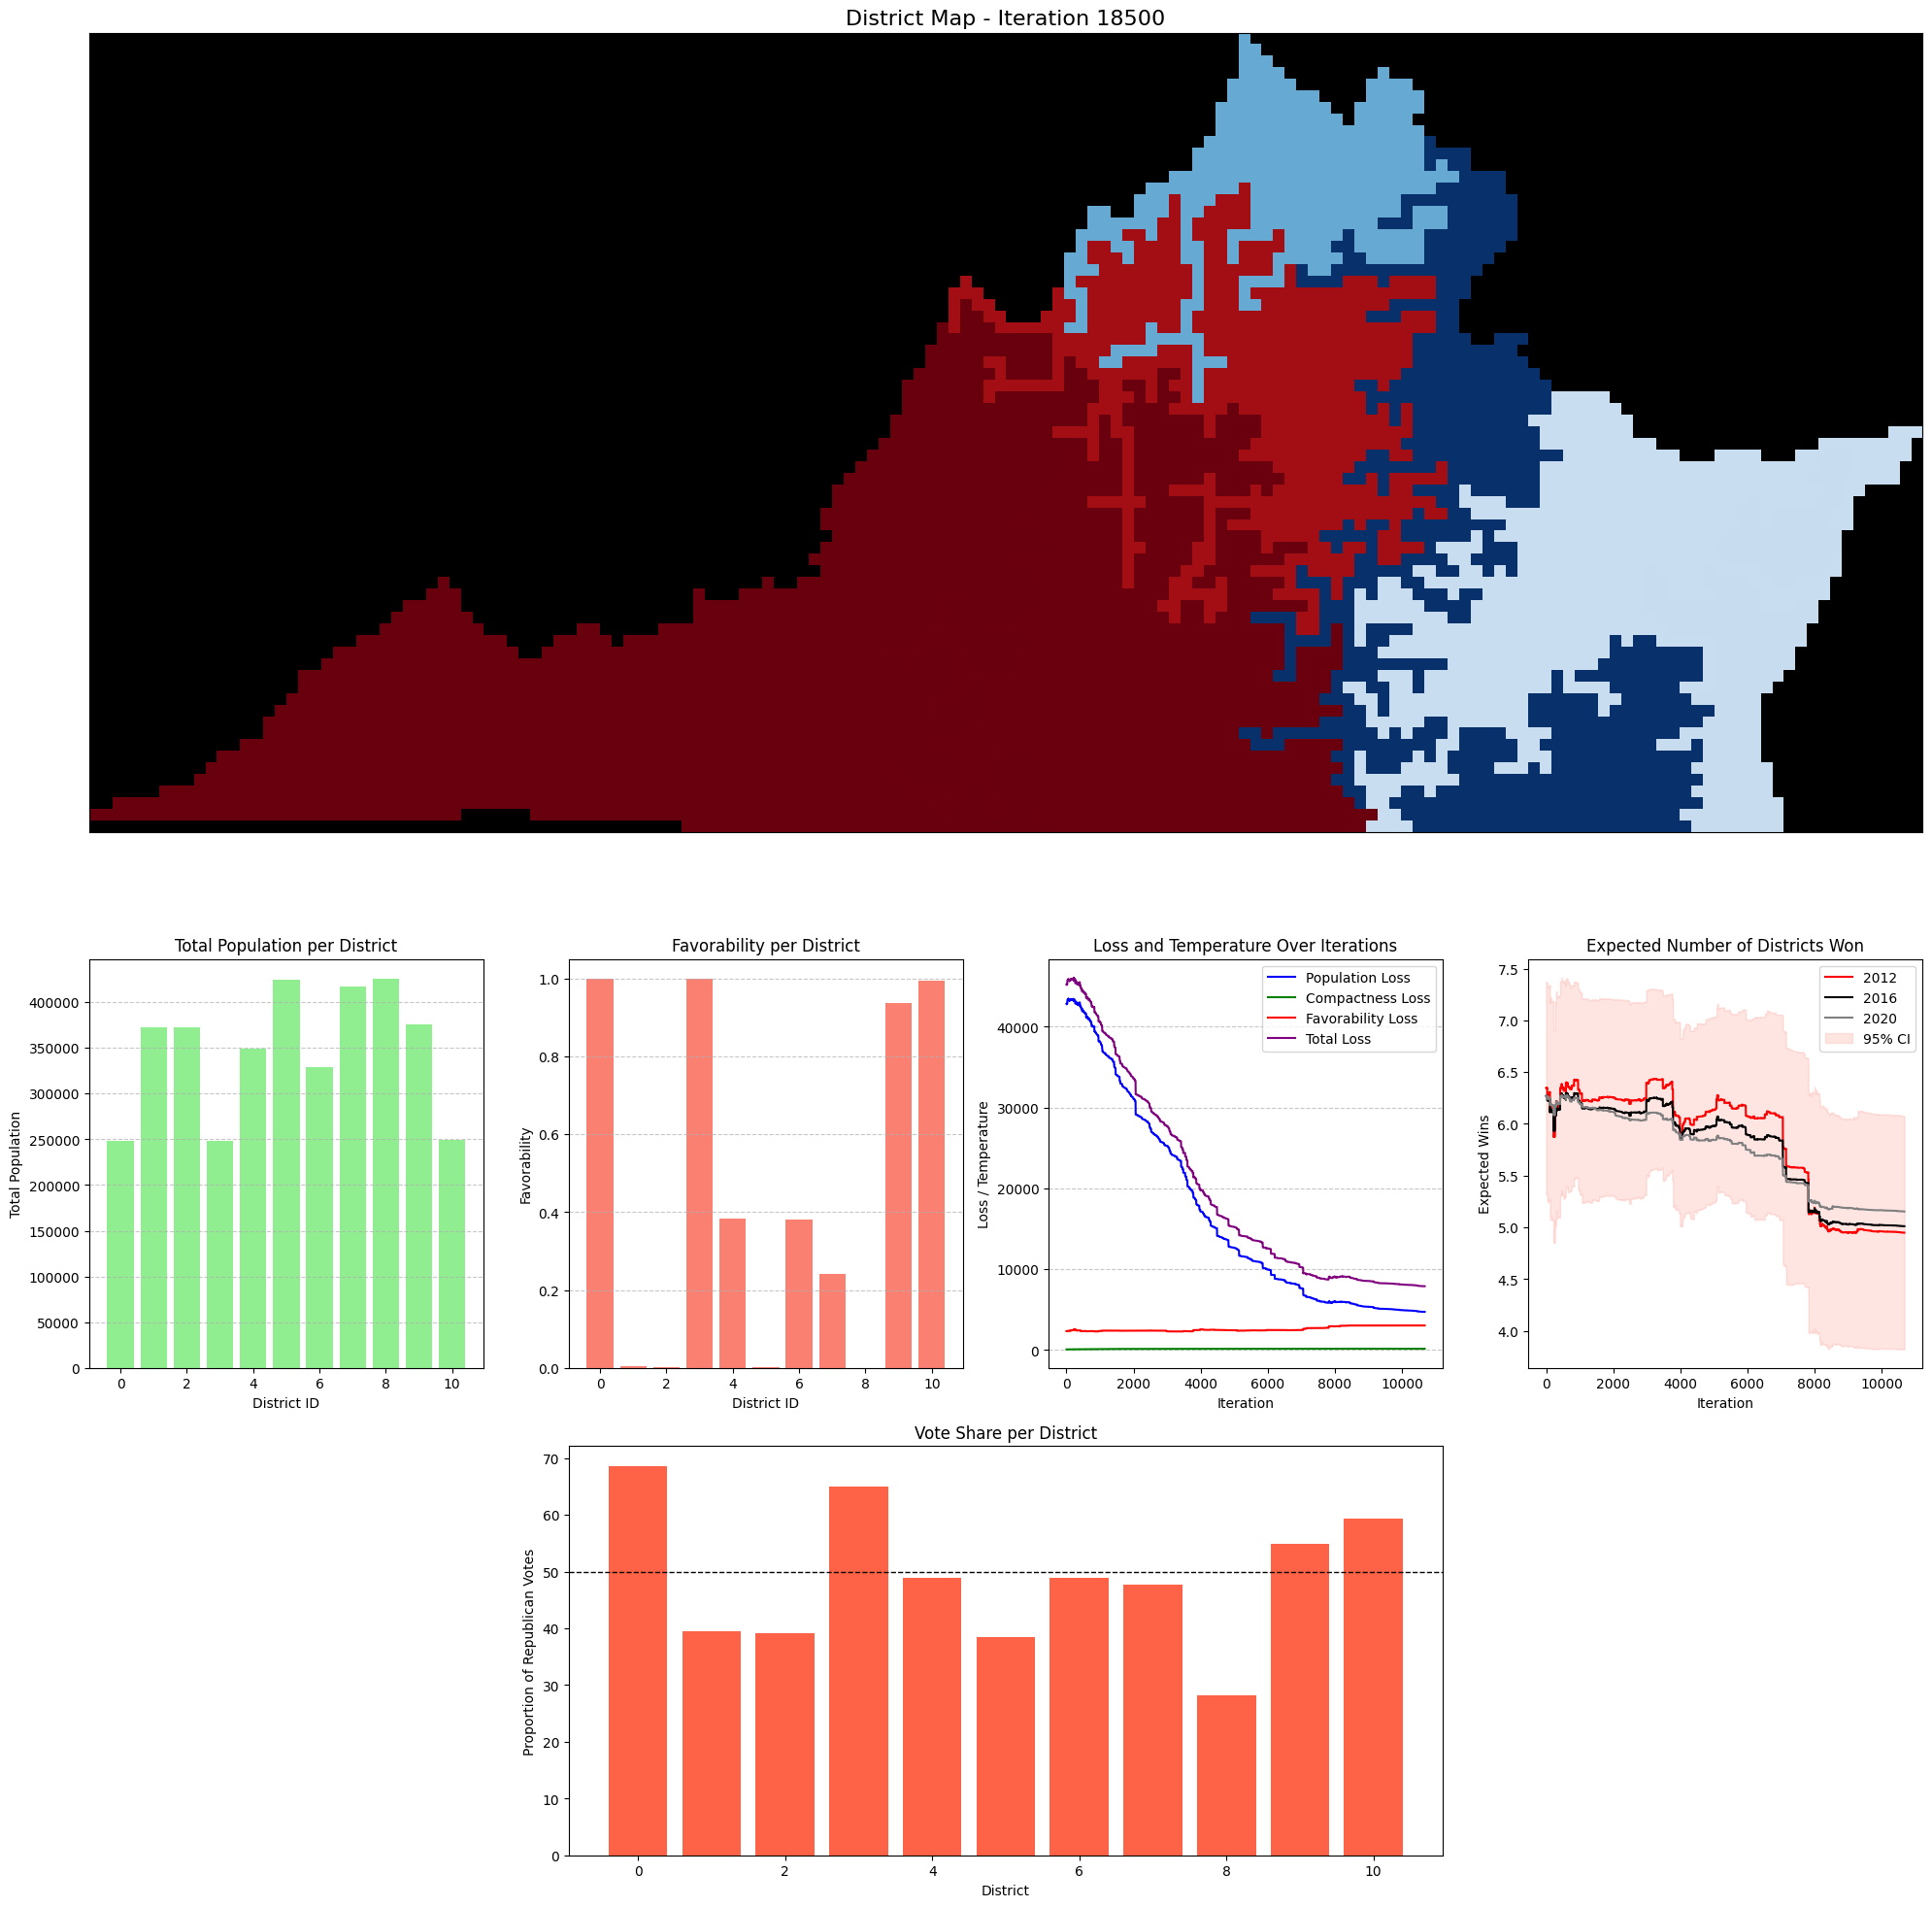

KeyboardInterrupt: 

In [59]:
optimized_district_map = flip_district_map_with_loss_optimized(
        population_masked,
        red_band,          # Pass the red_band for votes
        num_iterations=100000000000,
        target_pop=target_pop,
        initial_temp=1000,
        cooling_rate=0.995,
        num_districts=11,
        alpha=1,
        beta=0.0000001,
        gamma=500,                # Adjust gamma as needed (higher positive favors Red, more lower negative favors Blue)
        w0=0.11803320650970557,   # Adjust based on your logistic model
        w1=0.54105964,            # Adjust based on your logistic model
        w0_4=0.051217417264885934,
        w1_4=0.37283259,
        w0_8=0.06190221856727049,
        w1_8=0.22922328,
        visualize_every=500,
        random_seed=4
    )